In [49]:
# regression-multiple-methods.ipynb

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [50]:
# To ensure reproducibility
np.random.seed(42)

# Read data from Excel file
file_path = 'regression-multiple-methods.xlsx'
train_data = pd.read_excel(file_path, sheet_name='train')
test_data = pd.read_excel(file_path, sheet_name='test')

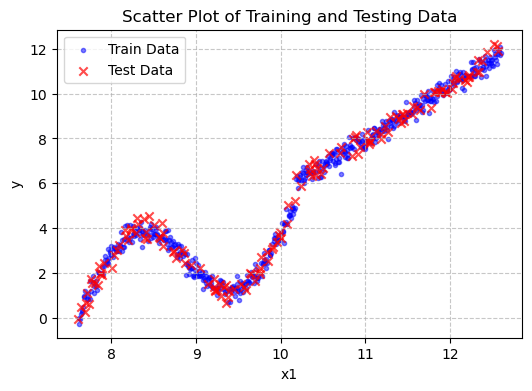

In [51]:
# Scatter Plot with 'x1' and 'y' columns ---

# Select the specified columns
x_train = train_data['x1']
y_train = train_data['y']
x_test = test_data['x1']
y_test = test_data['y']

# Create the scatter plot
plt.figure(figsize=(6, 4))

# Scatter plot for training data (blue circles)
plt.scatter(x_train, y_train, color='blue', label='Train Data', alpha=0.5, marker='.')

# Scatter plot for test data (red crosses)
plt.scatter(x_test, y_test, color='red', label='Test Data', alpha=0.7, marker='x')

# Add titles, labels, and legend
plt.title('Scatter Plot of Training and Testing Data')
plt.xlabel('x1')
plt.ylabel('y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

In [52]:
# Separate features and target variable in train data
X_train = train_data.drop(columns=['y'])
y_train = train_data['y']

# Separate features and target variable in test data
X_test = test_data.drop(columns=['y'])
y_test = test_data['y']

# From TA session on 8 Nov: Exercise 5 - outlier part to include

# Sachin Deshpande . 17:22
# X_train = np.array(list(X_train['x1']) + [X_train['x1'].mean() + x for x in np.random.randn(5)]).reshape(-1,1)
# y_train = np.array(list(y_train) + [y_train.max() + 4 + x for x in np.random.randn(5)])


In [53]:
# # Adding outliers (UNCOMMENT ONLY WHEN REQUIRED! SEE THE PROBLEM STATEMENTs ...)
# X_train = np.array(list(X_train['x1']) + [X_train['x1'].mean() + x for x in np.random.randn(5)]).reshape(-1,1)
# y_train = np.array(list(y_train) + [y_train.max() + 4 + x for x in np.random.randn(5)])

In [54]:
# Use PolynomialFeatures to create new features features
poly = PolynomialFeatures(degree=6)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [55]:
# standardization of the data
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [56]:
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_train_poly, columns=feature_names)
augmented_data['y'] = train_data['y']

# # Write dataframe to CSV
augmented_data.to_csv('augmented_train_data.csv', index=False)
####################################
####################################
# Save the augmented data set to a file for review

# Create dataframe with test data and additional features
# Get feature names
feature_names = poly.get_feature_names_out()
augmented_data = pd.DataFrame(X_test_poly, columns=feature_names)
augmented_data['y'] = test_data['y']

# # Write dataframe to CSV
augmented_data.to_csv('augmented_test_data.csv', index=False)
####################################

In [57]:
# Algorithms
algorithms = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(kernel='poly'),  # Adjust kernel as needed
    'RandomForest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'Neural Network-10': MLPRegressor(hidden_layer_sizes=[10], max_iter=20000),
}

# Metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

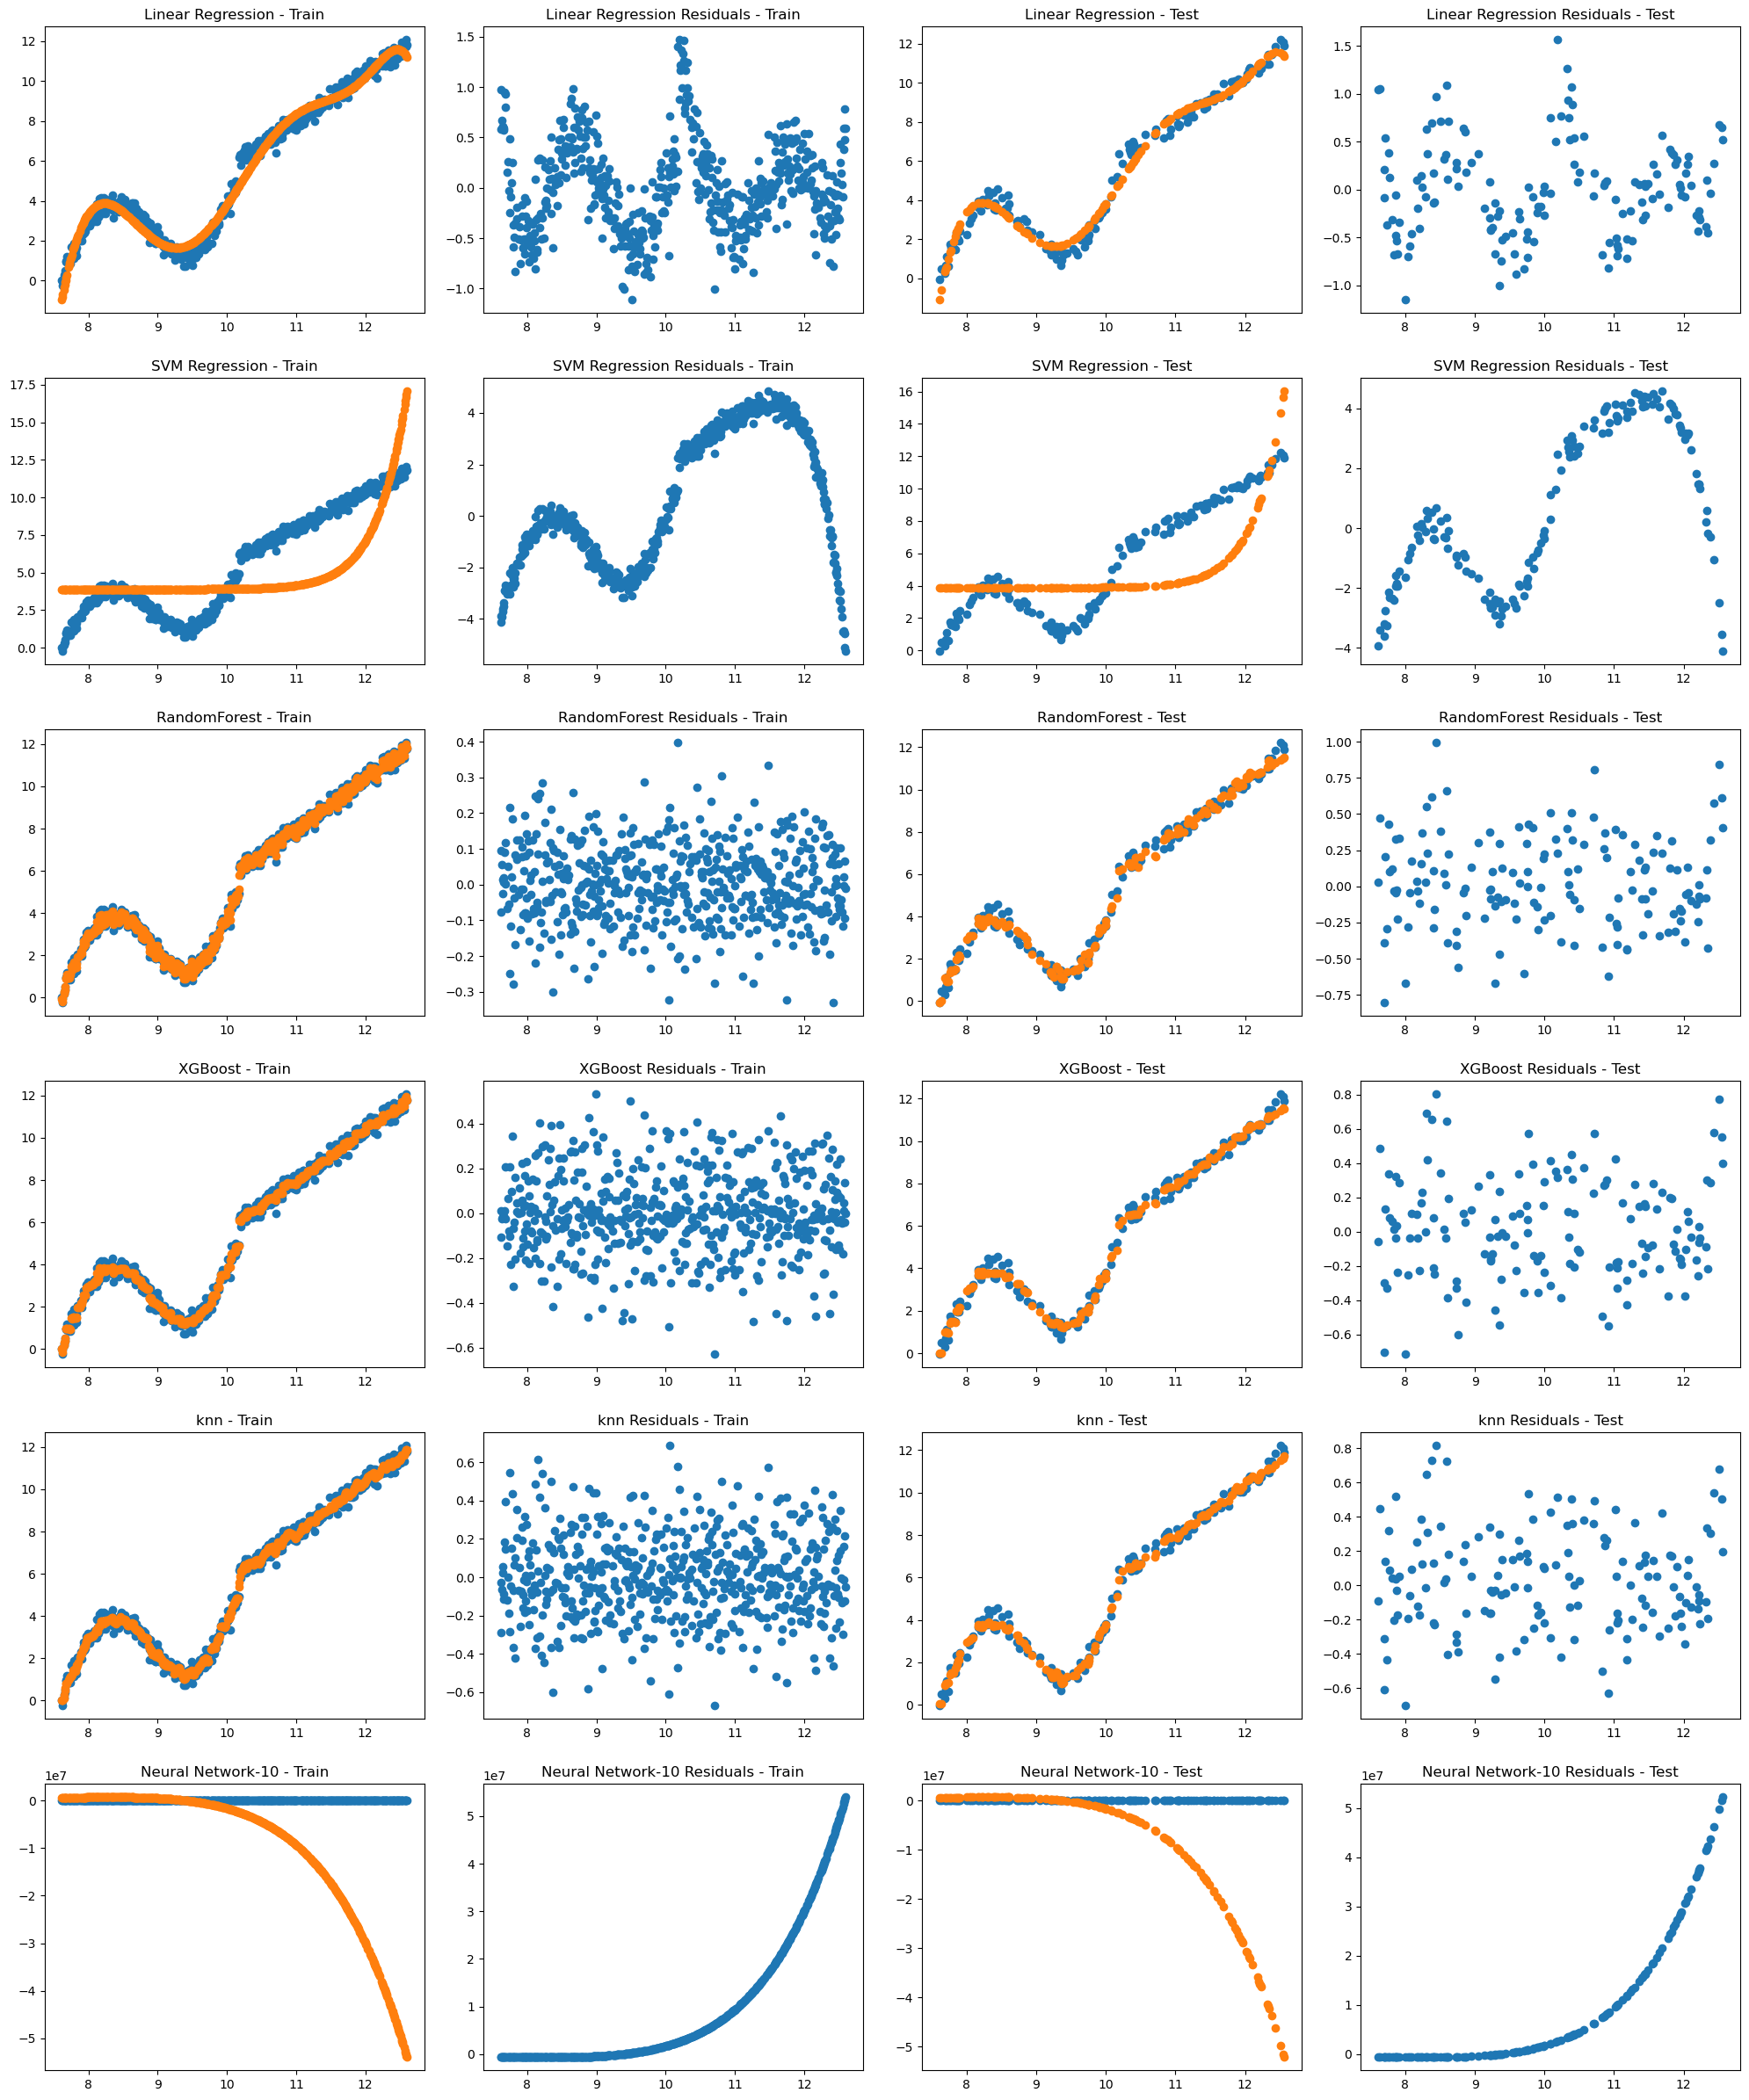

In [58]:
# Create a grid of subplots
fig, axs = plt.subplots(len(algorithms), 4, figsize=(20, 4 * len(algorithms)))
fig_row = -1

# Run the algorithms ... create metrics and plots
for algorithm_name, algorithm in algorithms.items():

    # Train model
    algorithm.fit(X_train_poly, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train_poly)

    # Test predictions
    y_test_pred = algorithm.predict(X_test_poly)

    # Train metrics
    r2_train = algorithm.score(X_train_poly, y_train)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)

    # Test metrics
    r2_test = algorithm.score(X_test_poly, y_test)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

    # Update metric tables
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'RMSE'] = rmse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'RMSE'] = rmse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test

    # Create the plots
    fig_row = fig_row+1

    axs[fig_row, 0].scatter(X_train, y_train)
    axs[fig_row, 0].scatter(X_train, y_train_pred)
    axs[fig_row, 0].set_title(algorithm_name + " - Train")

    axs[fig_row, 1].scatter(X_train, residuals_train)
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")

    axs[fig_row, 2].scatter(X_test, y_test)
    axs[fig_row, 2].scatter(X_test, y_test_pred)
    axs[fig_row, 2].set_title(algorithm_name + " - Test")

    axs[fig_row, 3].scatter(X_test, residuals_test)
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - Test")
############################

plt.tight_layout()
plt.show()

In [59]:
# Display the metrics' Tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")

print("Metrics - Test Data:\n")
print(metric_table_test.to_string())

Metrics - Train Data:

                      R-squared          RMSE  Durbin-Watson  Jarque-Bera    JB P-value
Linear Regression  9.827069e-01  4.543007e-01       0.572057    18.489216  9.663128e-05
SVM Regression     3.946295e-01  2.687931e+00       0.016682    43.824249  3.045687e-10
RandomForest       9.989994e-01  1.092800e-01       2.930430     3.250107  1.969011e-01
XGBoost            9.971463e-01  1.845492e-01       2.372918     1.046859  5.924852e-01
knn                9.958949e-01  2.213447e-01       2.505231     0.733304  6.930509e-01
Neural Network-10 -2.457190e+13  1.712485e+07       0.000101   245.456190  5.010322e-54
-------------------------------------------------
Metrics - Test Data:

                      R-squared          RMSE  Durbin-Watson  Jarque-Bera    JB P-value
Linear Regression  9.801501e-01  4.960630e-01       0.707796     4.669791  9.682060e-02
SVM Regression     4.252236e-01  2.669357e+00       0.030947    13.031702  1.479796e-03
RandomForest       9.9176

In [60]:
print("eod")

eod
